# Fit empirical (cross) (co)variogram by non-linear least squares optimization

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import variogram as vgm

In [4]:
# Analysis variables
year = 2019
tol = 500
time_lag = 1

In [5]:
# Get data: detrended 5-degree monthly average, cont. US
df = pd.read_csv("../data/exp_pro/OCO2_5deg_monthly_conus.csv")

# Isolate year
df["time"] = pd.to_datetime(df["time"])
df = df[df.time.dt.year == year]

# Standardize data locally
columns = ["xco2_res", "sif_res"]
df[columns] = df.groupby(["lon", "lat"])[columns].transform(lambda x: (x - x.mean()) / x.std())

df.head()

,lat,lon,time,sif_res,xco2_res
52,12.5,-92.5,2019-01-01,-0.542864,-0.165133
53,12.5,-92.5,2019-02-01,-1.047602,0.325714
54,12.5,-92.5,2019-03-01,-1.555631,0.840372
55,12.5,-92.5,2019-04-01,-0.168187,1.615102
56,12.5,-92.5,2019-05-01,0.235828,1.042413


In [6]:
space_lags = np.linspace(0, 5e3, 50)

df_vgm = vgm.empirical_variogram(
    df,
    ["xco2_res", "sif_res"],
    space_lags,
    tol=tol,
    time_lag=0,
    cross=False,
)
df_cov = vgm.empirical_variogram(
    df,
    ["xco2_res", "sif_res"],
    space_lags,
    tol=tol,
    time_lag=time_lag,
    covariogram=True,
)

In [18]:
df_cov.head()

,lag,xco2_res,sif_res,xco2_res:sif_res,cross_fit
0,0.000000,0.726492,0.609633,-0.250225,1.000000e-02
1,102.040816,0.732264,0.572802,-0.245046,5.122701e-274
2,204.081633,0.734790,0.592201,-0.259037,0.000000e+00
3,306.122449,0.732225,0.553962,-0.245178,0.000000e+00
4,408.163265,0.732516,0.560531,-0.246184,0.000000e+00


In [16]:
vgm_guess = [0.4, 4e3, 0.1]
cov_guess = [0.25, 4e3, 0.0]

xco2_params, df_vgm["xco2_fit"] = vgm.fit_variogram(df_vgm["lag"], df_vgm["xco2_res"], vgm_guess)
sif_params, df_vgm["sif_fit"] = vgm.fit_variogram(df_vgm["lag"], df_vgm["sif_res"], vgm_guess)
cross_params, df_cov["cross_fit"] = vgm.fit_variogram(df_cov["lag"], df_cov["xco2_res:sif_res"], cov_guess, covariogram=True)

print(sif_params)
df_cov.head()

[7.52535450e-01 1.52428222e+03 3.43726673e-01]


,lag,xco2_res,sif_res,xco2_res:sif_res,cross_fit
0,0.000000,0.726492,0.609633,-0.250225,1.000000e-02
1,102.040816,0.732264,0.572802,-0.245046,5.122701e-274
2,204.081633,0.734790,0.592201,-0.259037,0.000000e+00
3,306.122449,0.732225,0.553962,-0.245178,0.000000e+00
4,408.163265,0.732516,0.560531,-0.246184,0.000000e+00


<AxesSubplot:xlabel='lag'>

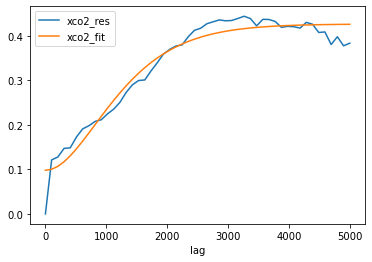

In [15]:
df_vgm.plot(x="lag", y=["xco2_res", "xco2_fit"])